
## NutriClass: Food Classification Using Nutritional Data
This Jupyter Notebook provides a step-by-step implementation of the NutriClass project, covering data understanding, preprocessing, feature engineering, multi-class classification, and model evaluation.

## 1. Setup and Library Installation
First, let's ensure all necessary Python libraries are installed.

In [ ]:
# Install necessary libraries (run this cell once)
!pip install pandas scikit-learn matplotlib seaborn numpy xgboost


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')



## 2. Configuration
Define constants for file paths and target column.

In [6]:
# --- Configuration ---
DATASET_PATH = os.path.join('/content/Dataset.csv') # Assumes Dataset.csv is in a 'data' subfolder
TARGET_COLUMN = 'Meal_Type' # Your target column for classification


In [3]:
# Feature Engineering Flags
APPLY_PCA = True # Set to True to apply PCA, False otherwise
APPLY_FEATURE_SELECTION = False # Set to True to apply feature selection, False otherwise

## 3. Phase 1: Data Understanding and Exploration
Load the dataset and perform initial checks.

Dataset loaded successfully. Shape: (31700, 16)

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31700 entries, 0 to 31699
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Calories            31325 non-null  float64
 1   Protein             31325 non-null  float64
 2   Fat                 31325 non-null  float64
 3   Carbs               31325 non-null  float64
 4   Sugar               31325 non-null  float64
 5   Fiber               31325 non-null  float64
 6   Sodium              31325 non-null  float64
 7   Cholesterol         31325 non-null  float64
 8   Glycemic_Index      31325 non-null  float64
 9   Water_Content       31325 non-null  float64
 10  Serving_Size        31325 non-null  float64
 11  Meal_Type           31700 non-null  object 
 12  Preparation_Method  31700 non-null  object 
 13  Is_Vegan            31700 non-null  bool   
 14  Is_Gluten_Free      31700 non-null 

/tmp/ipython-input-197843142.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=TARGET_COLUMN, order=df[TARGET_COLUMN].value_counts().index, palette='viridis')


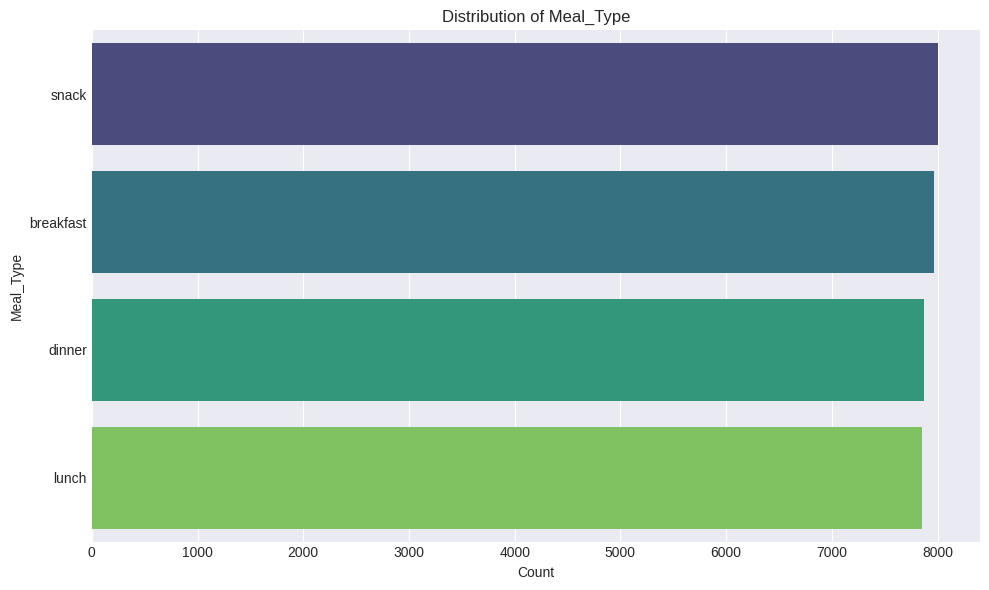

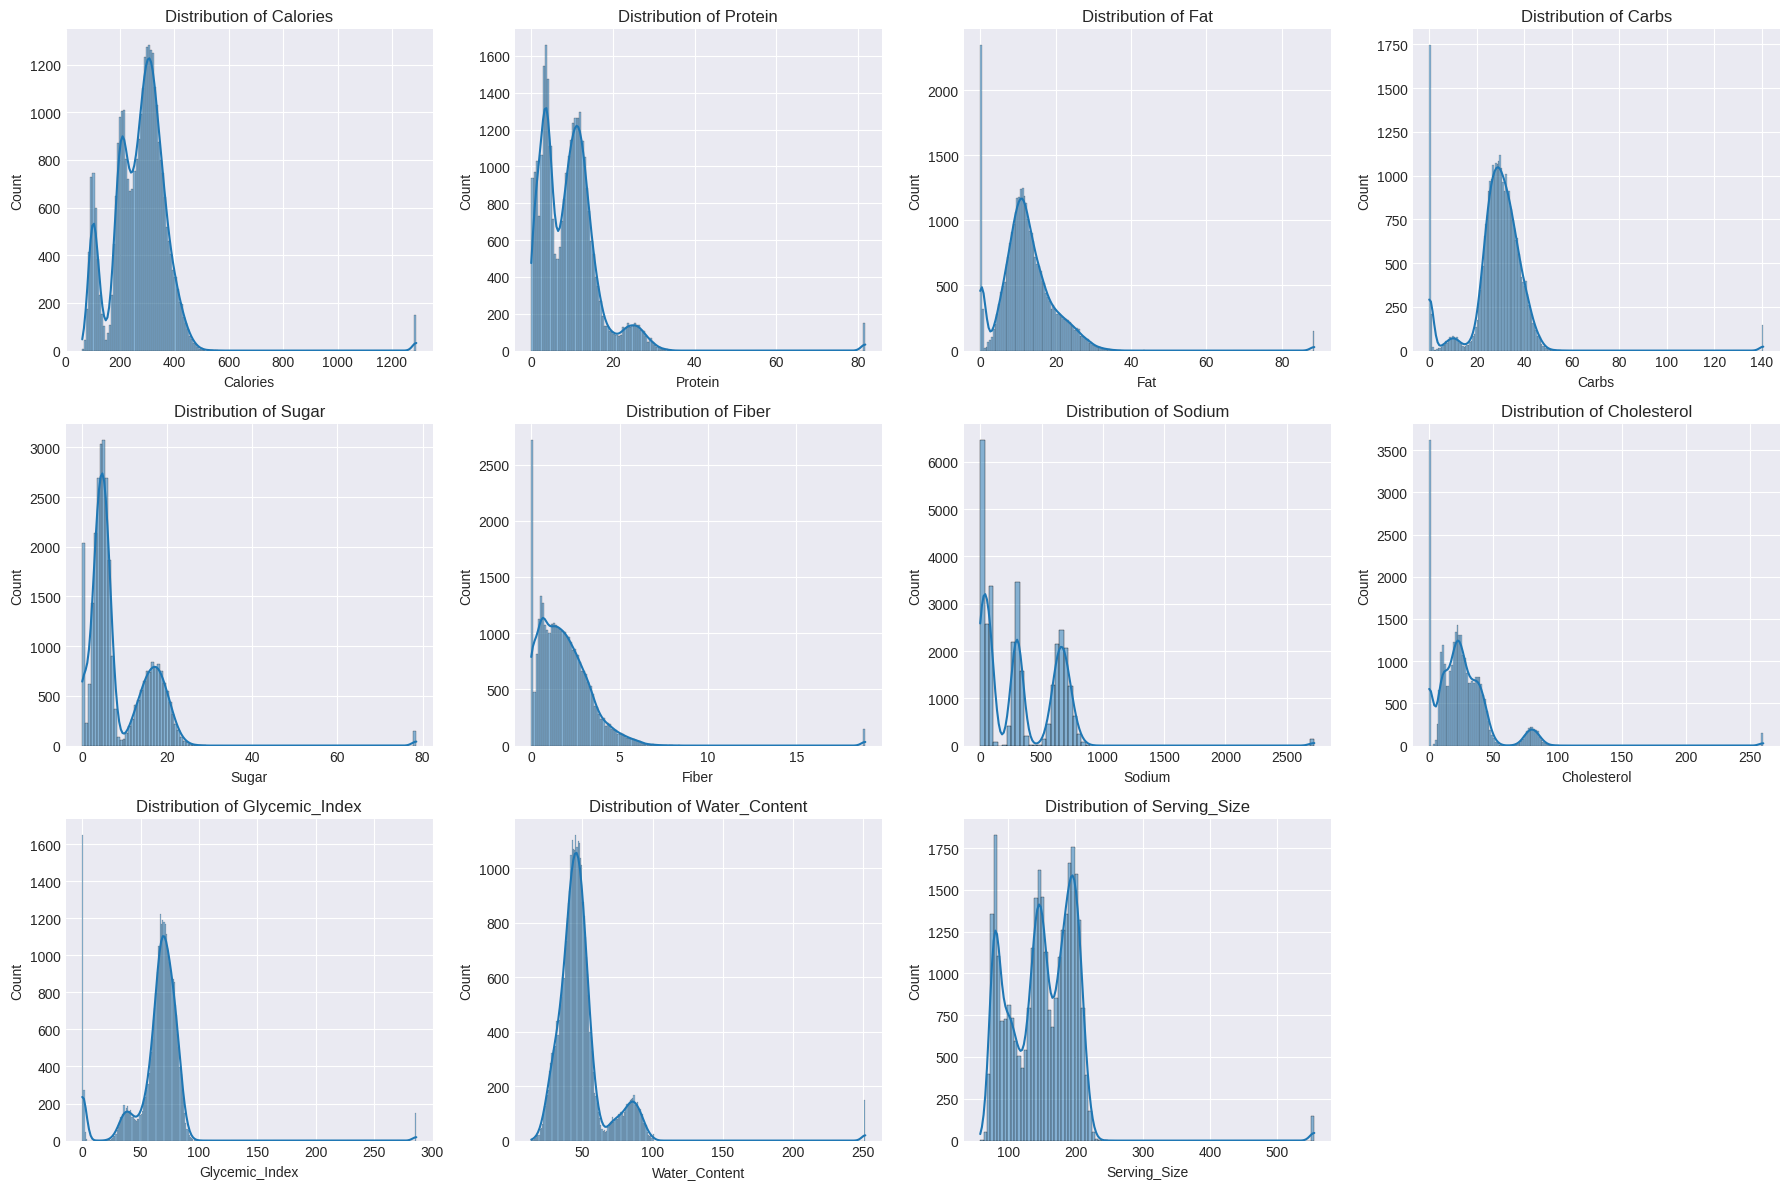

In [7]:
# --- Data Loading Function ---
def load_data(file_path):
    """Loads the dataset from the specified CSV file."""
    if not os.path.exists(file_path):
        print(f"Error: Dataset file not found at {file_path}. Please ensure 'Dataset.csv' is in the 'data/' folder.")
        return None
    try:
        df = pd.read_csv(file_path)
        print(f"Dataset loaded successfully. Shape: {df.shape}")
        return df
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None

# --- Data Exploration Function ---
def explore_data(df):
    """Performs initial data exploration."""
    print("\n--- Data Info ---")
    df.info()

    print("\n--- Descriptive Statistics ---")
    print(df.describe())

    print("\n--- Missing Values ---")
    print(df.isnull().sum())

    print("\n--- Duplicate Rows ---")
    print(f"Number of duplicate rows: {df.duplicated().sum()}")

    if TARGET_COLUMN in df.columns:
        print(f"\n--- Class Distribution ({TARGET_COLUMN}) ---")
        print(df[TARGET_COLUMN].value_counts())
        plt.figure(figsize=(10, 6))
        # Updated to use a 'viridis' palette for different colors
        sns.countplot(data=df, y=TARGET_COLUMN, order=df[TARGET_COLUMN].value_counts().index, palette='viridis')
        plt.title(f'Distribution of {TARGET_COLUMN}')
        plt.xlabel('Count')
        plt.ylabel(TARGET_COLUMN)
        plt.tight_layout()
        plt.show()
    else:
        print(f"\nWarning: '{TARGET_COLUMN}' column not found. Please adjust TARGET_COLUMN name.")

    # Visualize distributions of key nutritional features
    nutritional_cols = ['Calories', 'Protein', 'Fat', 'Carbs', 'Sugar', 'Fiber', 'Sodium', 'Cholesterol', 'Glycemic_Index', 'Water_Content', 'Serving_Size']
    plt.figure(figsize=(18, 12))
    for i, col in enumerate(nutritional_cols):
        if col in df.columns and df[col].dtype in ['float64', 'int64']:
            plt.subplot(3, 4, i + 1)
            sns.histplot(df[col], kde=True)
            plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

# Load and explore data
food_df = load_data(DATASET_PATH)
if food_df is not None:
    explore_data(food_df.copy()) # Use a copy for exploration


## 4. Phase 2: Data Preprocessing
Handle missing values, outliers, and scale numerical features.


In [8]:
# --- Preprocessing Functions ---
def handle_missing_values(df, strategy='mean', numerical_cols=None):
    """Imputes missing values in numerical columns."""
    if numerical_cols is None:
        numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
    # Ensure target column is not in numerical_cols if it's numerical
    numerical_cols = [col for col in numerical_cols if col != TARGET_COLUMN]

    if numerical_cols:
        imputer = SimpleImputer(strategy=strategy)
        df[numerical_cols] = imputer.fit_transform(df[numerical_cols])
        print("Missing values handled.")
    else:
        print("No numerical columns to impute missing values.")
    return df

def handle_outliers(df, numerical_cols=None, method='iqr', cap_factor=1.5):
    """Detects and caps/removes outliers using IQR or Z-score."""
    if numerical_cols is None:
        numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
    numerical_cols = [col for col in numerical_cols if col != TARGET_COLUMN]

    if not numerical_cols:
        print("No numerical columns to handle outliers.")
        return df

    for col in numerical_cols:
        if method == 'iqr':
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - cap_factor * IQR
            upper_bound = Q3 + cap_factor * IQR
            # Cap outliers
            df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
            df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
        # Add 'zscore' method if needed
    print("Outliers handled (capped).")
    return df

def scale_features(df, numerical_cols=None, scaler_type='standard'):
    """Scales numerical features using StandardScaler or MinMaxScaler."""
    if numerical_cols is None:
        numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
    numerical_cols = [col for col in numerical_cols if col != TARGET_COLUMN]

    if not numerical_cols:
        print("No numerical columns to scale.")
        return df, None

    if scaler_type == 'standard':
        scaler = StandardScaler()
    elif scaler_type == 'minmax':
        scaler = MinMaxScaler()
    else:
        raise ValueError("scaler_type must be 'standard' or 'minmax'")

    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    print(f"Features scaled using {scaler_type} scaler.")
    return df, scaler # Return scaler for inverse transform if needed later

def preprocess_data(df, target_column):
    """Orchestrates all preprocessing steps."""
    initial_rows = len(df)
    df.drop_duplicates(inplace=True)
    print(f"Removed {initial_rows - len(df)} duplicate rows.")

    numerical_cols = [col for col in df.select_dtypes(include=np.number).columns if col != target_column]

    df = handle_missing_values(df, numerical_cols=numerical_cols)
    df = handle_outliers(df, numerical_cols=numerical_cols)
    df, scaler = scale_features(df, numerical_cols=numerical_cols)

    return df, scaler

# Run preprocessing
if food_df is not None:
    preprocessed_df, scaler = preprocess_data(food_df.copy(), target_column=TARGET_COLUMN)
    print("\nSample of Preprocessed Data (numerical features scaled):")
    print(preprocessed_df.head())

Removed 313 duplicate rows.
Missing values handled.
Outliers handled (capped).
Features scaled using standard scaler.

Sample of Preprocessed Data (numerical features scaled):
   Calories   Protein       Fat     Carbs     Sugar     Fiber    Sodium  \
0  0.244017  0.836562  0.317194  0.736158 -0.533391 -0.402712  1.147822   
1 -0.647767 -0.823876 -0.073698 -0.723778  1.252363 -1.277468 -0.925955   
2  0.704955  0.834398  1.181299  0.034833 -0.312786 -0.777102  1.203764   
3 -0.814536  0.045503 -1.022840  0.352168 -0.819149 -0.087024 -0.094350   
4  0.061077 -0.497161  0.642043  0.068457  1.408176 -0.271443 -0.110234   

   Cholesterol  Glycemic_Index  Water_Content  Serving_Size Meal_Type  \
0    -0.007831        1.144400      -0.093073      1.090114    dinner   
1     0.535879        0.276298       0.246747     -1.023759     snack   
2     0.565961       -0.225699      -0.542582      1.122121     snack   
3     0.197750        0.216258       0.861306     -0.304811     lunch   
4    -0.

## 5. Phase 3: Feature Engineering
Encode categorical features and apply dimensionality reduction (PCA or Feature Selection).


In [9]:
# --- Feature Engineering Functions ---
def encode_labels(df_series, target_column):
    """Encodes the target categorical labels into numerical format."""
    le = LabelEncoder()
    # Ensure we are working on a copy to avoid SettingWithCopyWarning
    df_series_copy = df_series.copy()
    df_series_copy = le.fit_transform(df_series_copy)
    print(f"Target column '{target_column}' encoded.")
    return df_series_copy, le # Return encoder for inverse transform to get original labels

def apply_pca(X, n_components=0.95):
    """Applies PCA for dimensionality reduction."""
    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X)
    print(f"PCA applied. Original features: {X.shape[1]}, Components: {X_pca.shape[1]}")
    return X_pca, pca

def select_features(X, y, k='all', score_func=f_classif):
    """Selects top K features using SelectKBest."""
    selector = SelectKBest(score_func=score_func, k=k)
    X_selected = selector.fit_transform(X, y)
    selected_features_indices = selector.get_support(indices=True)
    print(f"Selected {len(selected_features_indices)} features using SelectKBest.")
    return X_selected, selector, selected_features_indices

def feature_engineer(df, target_column, apply_pca_flag=False, apply_feature_selection_flag=False):
    """Orchestrates feature engineering steps."""
    # Separate features (X) and target (y)
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # 1. Encode target variable first
    y_encoded, label_encoder = encode_labels(y, target_column)

    # 2. Identify categorical and numerical features for X
    # Exclude boolean columns if they are already 0/1, otherwise include in categorical
    categorical_cols = X.select_dtypes(include='object').columns.tolist()

    # Handle boolean columns if they are not already 0/1 (e.g., 'True'/'False' strings)
    # Convert them to numerical (0/1) before one-hot encoding or scaling
    for col in X.select_dtypes(include='bool').columns:
        X[col] = X[col].astype(int) # Convert True/False to 1/0

    # 3. Apply One-Hot Encoding to identified categorical columns in X
    preprocessor = None
    if categorical_cols:
        print(f"Applying One-Hot Encoding to: {categorical_cols}")
        preprocessor = ColumnTransformer(
            transformers=[
                ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
            ],
            remainder='passthrough' # Keep other (numerical) columns
        )
        X_processed = preprocessor.fit_transform(X)
        print("One-Hot Encoding complete.")
    else:
        X_processed = X.values # Convert to numpy array if no categorical columns to encode

    # 4. Apply PCA or Feature Selection on the processed numerical features
    feature_transformer = None # To store PCA or SelectKBest object
    if apply_pca_flag:
        print("Applying PCA...")
        X_transformed, feature_transformer = apply_pca(X_processed)
    elif apply_feature_selection_flag:
        print("Applying Feature Selection (SelectKBest)...")
        X_transformed, feature_transformer, selected_indices = select_features(X_processed, y_encoded)
    else:
        X_transformed = X_processed # If no PCA or feature selection, use the processed X

    return X_transformed, y_encoded, label_encoder, feature_transformer, preprocessor # Return preprocessor for feature names if needed

# Run feature engineering
if preprocessed_df is not None:
    X_transformed, y_encoded, label_encoder, feature_transformer, preprocessor = \
        feature_engineer(preprocessed_df.copy(), TARGET_COLUMN,
                         apply_pca_flag=APPLY_PCA,
                         apply_feature_selection_flag=APPLY_FEATURE_SELECTION)

    print(f"\nShape of transformed features (X): {X_transformed.shape}")
    print(f"Shape of encoded target (y): {y_encoded.shape}")
    print(f"Original Food Categories: {label_encoder.classes_}")

Target column 'Meal_Type' encoded.
Applying One-Hot Encoding to: ['Preparation_Method', 'Food_Name']
One-Hot Encoding complete.
Applying PCA...
PCA applied. Original features: 27, Components: 12

Shape of transformed features (X): (31387, 12)
Shape of encoded target (y): (31387,)
Original Food Categories: ['breakfast' 'dinner' 'lunch' 'snack']


## 6. Phase 4: Data Splitting
Split the data into training and testing sets.

In [10]:
# --- Data Splitting ---
if 'X_transformed' in locals() and 'y_encoded' in locals():
    X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded)
    print("\nData split into training and testing sets.")
    print(f"Training set shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Testing set shape: X={X_test.shape}, y={y_test.shape}")
else:
    print("Data not ready for model training. Please check previous steps.")



Data split into training and testing sets.
Training set shape: X=(23540, 12), y=(23540,)
Testing set shape: X=(7847, 12), y=(7847,)


## 7. Phase 5: Model Training, Tuning, and Evaluation
Train and evaluate multiple classifiers, including hyperparameter tuning.


In [11]:
# --- Define Classifiers and Parameter Grids ---
# A dictionary of classifiers to be trained
classifiers = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=100, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(random_state=42, probability=True, class_weight='balanced'),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss', tree_method='hist'),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# A dictionary of hyperparameter grids for GridSearchCV
param_grids = {
    "Logistic Regression": {
        'C': [0.1, 1, 10],
        'solver': ['liblinear', 'lbfgs']
    },
    "Decision Tree": {
        'max_depth': [3],
        'min_samples_leaf': [1, 5, 10]
    },
    "Random Forest": {
        'n_estimators': [100],
        'max_depth': [3],
        'min_samples_leaf': [1, 5]
    },
    "K-Nearest Neighbors": {
        'n_neighbors': [3],
        'weights': ['uniform', 'distance']
    },
    # Simplified grid for SVC to avoid cloud notebook timeouts.
    # We will skip GridSearchCV for SVC in the training loop.
    "Support Vector Machine": {
        'C': [1],
        'kernel': ['rbf']
    },
    "XGBoost": {
        'n_estimators': [100],
        'learning_rate': [0.1],
        'max_depth': [3, 5, 7]
    },
    "Gradient Boosting": {
        'n_estimators': [100],
        'learning_rate': [0.1],
        'max_depth': [3]
    }
}


In [14]:
# --- Define Classifiers and Parameter Grids ---
# A dictionary of classifiers to be trained
classifiers = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=100, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(random_state=42, probability=True, class_weight='balanced'),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss', tree_method='hist'),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# A dictionary of hyperparameter grids for GridSearchCV
param_grids = {
    "Logistic Regression": {
        'C': [0.1, 1, 10],
        'solver': ['liblinear', 'lbfgs']
    },
    "Decision Tree": {
        'max_depth': [3],
        'min_samples_leaf': [1, 5, 10]
    },
    "Random Forest": {
        'n_estimators': [100],
        'max_depth': [3],
        'min_samples_leaf': [1, 5]
    },
    "K-Nearest Neighbors": {
        'n_neighbors': [3],
        'weights': ['uniform', 'distance']
    },
    # Simplified grid for SVC to avoid cloud notebook timeouts.
    # We will skip GridSearchCV for SVC in the training loop.
    "Support Vector Machine": {
        'C': [1],
        'kernel': ['rbf']
    },
    "XGBoost": {
        'n_estimators': [100],
        'learning_rate': [0.1],
        'max_depth': [3, 5, 7]
    },
    "Gradient Boosting": {
        'n_estimators': [100],
        'learning_rate': [0.1],
        'max_depth': [3]
    }
}



--- Processing Logistic Regression ---
Performing GridSearchCV for Logistic Regression...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters found: {'C': 10, 'solver': 'liblinear'}
Best f1_weighted score: 0.2413

--- LogisticRegression Evaluation ---
Accuracy: 0.2539
Precision (weighted): 0.2537
Recall (weighted): 0.2539
F1-score (weighted): 0.2446

Classification Report:
              precision    recall  f1-score   support

   breakfast       0.25      0.29      0.27      1968
      dinner       0.26      0.13      0.17      1950
       lunch       0.25      0.22      0.23      1948
       snack       0.26      0.38      0.31      1981

    accuracy                           0.25      7847
   macro avg       0.25      0.25      0.24      7847
weighted avg       0.25      0.25      0.24      7847


Confusion Matrix:


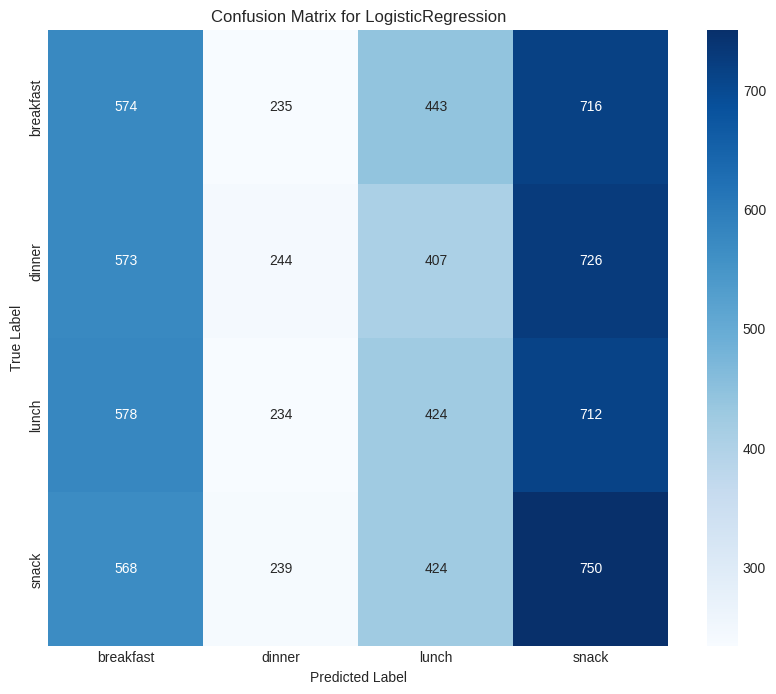


--- Processing Decision Tree ---
Performing GridSearchCV for Decision Tree...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters found: {'max_depth': 3, 'min_samples_leaf': 10}
Best f1_weighted score: 0.1276

--- DecisionTreeClassifier Evaluation ---
Accuracy: 0.2516
Precision (weighted): 0.1676
Recall (weighted): 0.2516
F1-score (weighted): 0.1052

Classification Report:
              precision    recall  f1-score   support

   breakfast       0.17      0.01      0.01      1968
      dinner       0.25      0.00      0.00      1950
       lunch       0.00      0.00      0.00      1948
       snack       0.25      0.99      0.40      1981

    accuracy                           0.25      7847
   macro avg       0.17      0.25      0.10      7847
weighted avg       0.17      0.25      0.11      7847


Confusion Matrix:


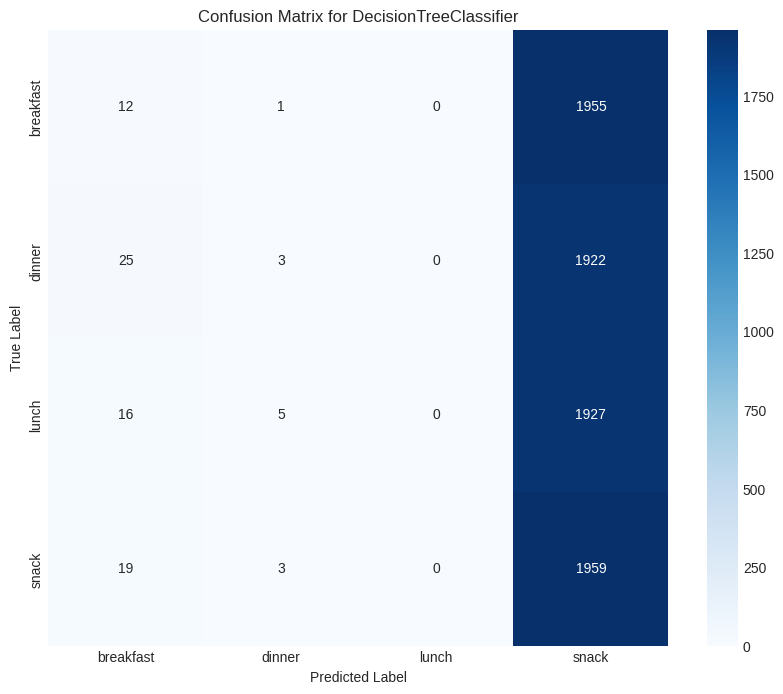


--- Processing Random Forest ---
Performing GridSearchCV for Random Forest...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters found: {'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 100}
Best f1_weighted score: 0.2478

--- RandomForestClassifier Evaluation ---
Accuracy: 0.2498
Precision (weighted): 0.2493
Recall (weighted): 0.2498
F1-score (weighted): 0.2471

Classification Report:
              precision    recall  f1-score   support

   breakfast       0.25      0.24      0.25      1968
      dinner       0.23      0.17      0.20      1950
       lunch       0.24      0.32      0.27      1948
       snack       0.27      0.27      0.27      1981

    accuracy                           0.25      7847
   macro avg       0.25      0.25      0.25      7847
weighted avg       0.25      0.25      0.25      7847


Confusion Matrix:


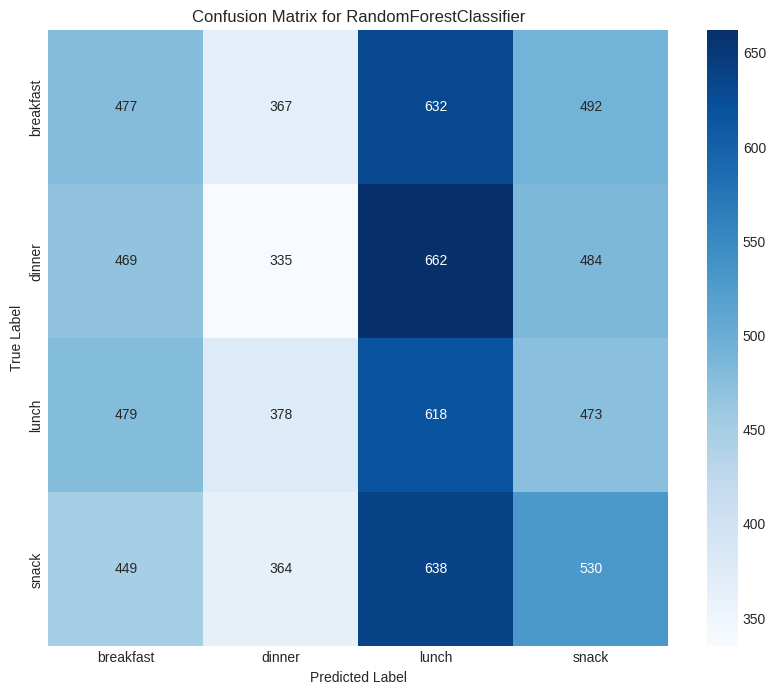


--- Processing K-Nearest Neighbors ---
Performing GridSearchCV for K-Nearest Neighbors...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters found: {'n_neighbors': 3, 'weights': 'distance'}
Best f1_weighted score: 0.2501

--- KNeighborsClassifier Evaluation ---
Accuracy: 0.2498
Precision (weighted): 0.2497
Recall (weighted): 0.2498
F1-score (weighted): 0.2497

Classification Report:
              precision    recall  f1-score   support

   breakfast       0.24      0.24      0.24      1968
      dinner       0.25      0.25      0.25      1950
       lunch       0.25      0.24      0.25      1948
       snack       0.26      0.26      0.26      1981

    accuracy                           0.25      7847
   macro avg       0.25      0.25      0.25      7847
weighted avg       0.25      0.25      0.25      7847


Confusion Matrix:


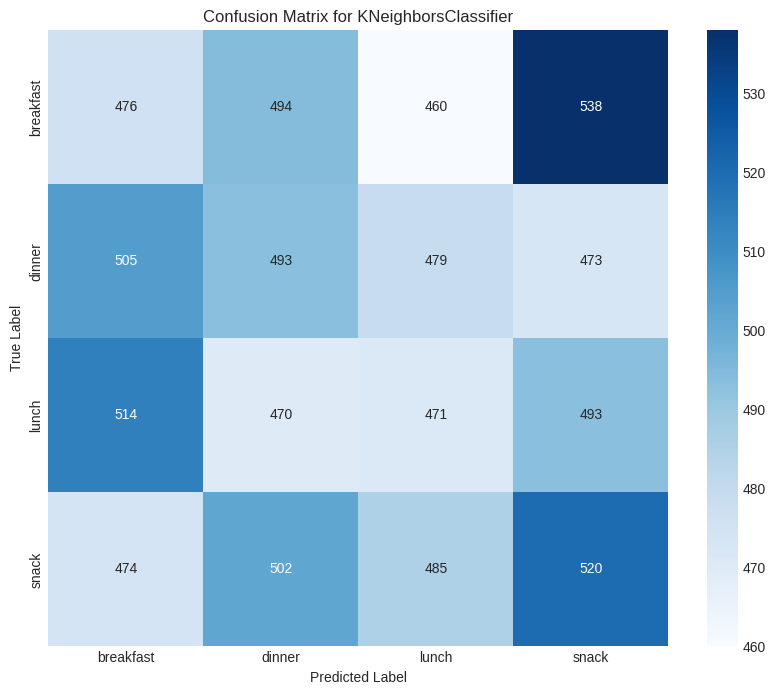


--- Processing Support Vector Machine ---
Performing GridSearchCV for Support Vector Machine...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found: {'C': 1, 'kernel': 'rbf'}
Best f1_weighted score: 0.2490

--- SVC Evaluation ---
Accuracy: 0.2508
Precision (weighted): 0.2506
Recall (weighted): 0.2508
F1-score (weighted): 0.2503

Classification Report:
              precision    recall  f1-score   support

   breakfast       0.25      0.28      0.27      1968
      dinner       0.24      0.22      0.23      1950
       lunch       0.24      0.24      0.24      1948
       snack       0.27      0.26      0.27      1981

    accuracy                           0.25      7847
   macro avg       0.25      0.25      0.25      7847
weighted avg       0.25      0.25      0.25      7847


Confusion Matrix:


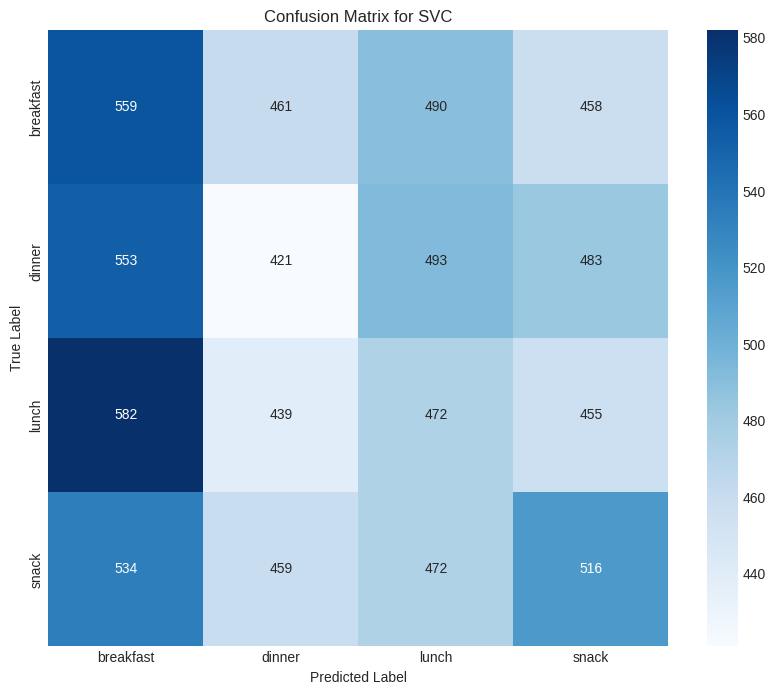


--- Processing XGBoost ---
Performing GridSearchCV for XGBoost...
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:33:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters found: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best f1_weighted score: 0.2547

--- XGBClassifier Evaluation ---
Accuracy: 0.2499
Precision (weighted): 0.2498
Recall (weighted): 0.2499
F1-score (weighted): 0.2497

Classification Report:
              precision    recall  f1-score   support

   breakfast       0.25      0.27      0.26      1968
      dinner       0.25      0.23      0.24      1950
       lunch       0.24      0.25      0.25      1948
       snack       0.26      0.26      0.26      1981

    accuracy                           0.25      7847
   macro avg       0.25      0.25      0.25      7847
weighted avg       0.25      0.25      0.25      7847


Confusion Matrix:


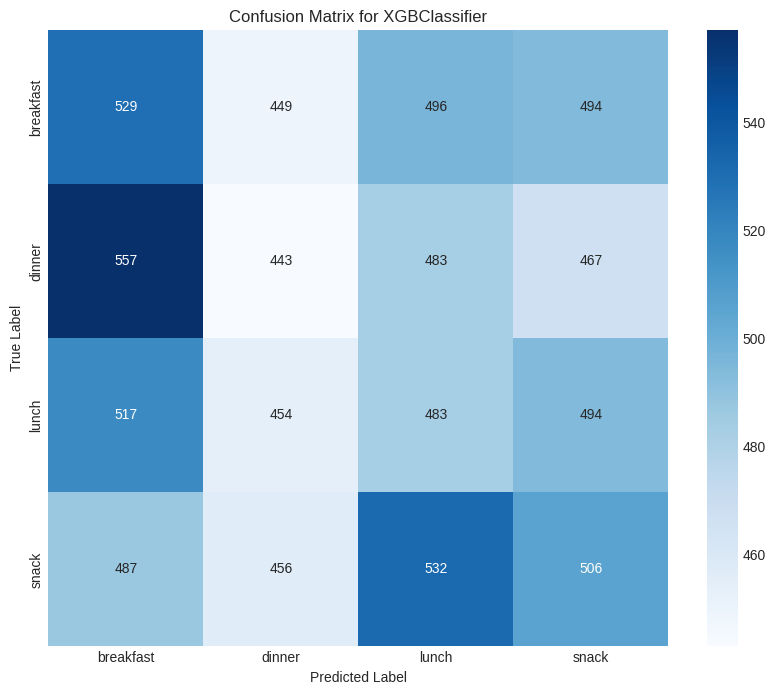


--- Processing Gradient Boosting ---
Performing GridSearchCV for Gradient Boosting...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best f1_weighted score: 0.2520

--- GradientBoostingClassifier Evaluation ---
Accuracy: 0.2531
Precision (weighted): 0.2524
Recall (weighted): 0.2531
F1-score (weighted): 0.2513

Classification Report:
              precision    recall  f1-score   support

   breakfast       0.27      0.24      0.25      1968
      dinner       0.24      0.19      0.21      1950
       lunch       0.25      0.26      0.26      1948
       snack       0.26      0.31      0.28      1981

    accuracy                           0.25      7847
   macro avg       0.25      0.25      0.25      7847
weighted avg       0.25      0.25      0.25      7847


Confusion Matrix:


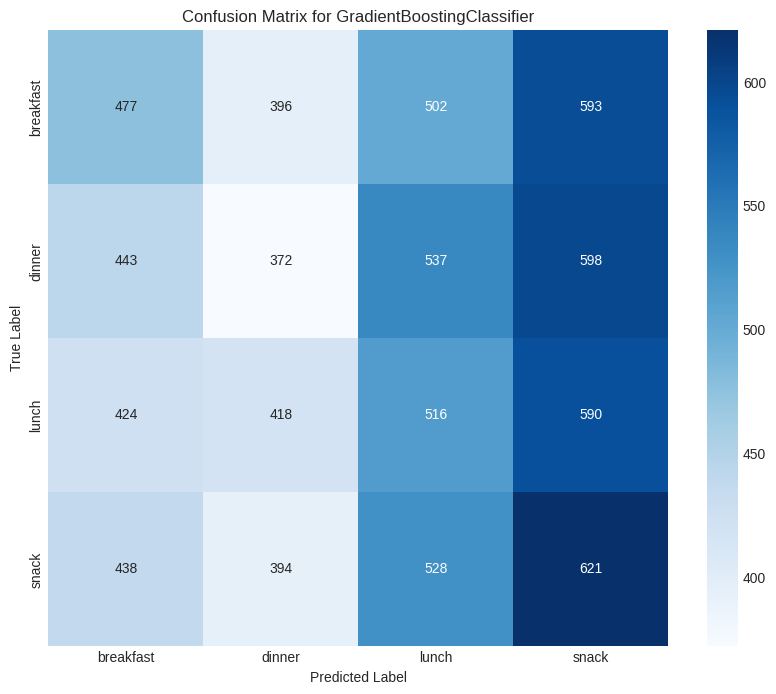

In [16]:
# --- Training and Evaluation Loop ---
def evaluate_model(model, X_test, y_test, class_names):
    """Evaluates a trained model and prints metrics."""
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted', zero_division=0)

    print(f"\n--- {type(model).__name__} Evaluation ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")
    print(f"F1-score (weighted): {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {type(model).__name__}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    return accuracy, precision, recall, f1, cm

def run_training_and_evaluation_loop(classifiers, param_grids, X_train, y_train, X_test, y_test, label_encoder):
    """Performs training, tuning, and evaluation for all classifiers."""
    results = {}
    class_names = label_encoder.inverse_transform(np.arange(len(label_encoder.classes_)))

    for name, model in classifiers.items():
        print(f"\n--- Processing {name} ---")
        if name in param_grids:
            print(f"Performing GridSearchCV for {name}...")
            grid_search = GridSearchCV(estimator=model, param_grid=param_grids[name], cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)
            grid_search.fit(X_train, y_train)
            print(f"Best parameters found: {grid_search.best_params_}")
            print(f"Best f1_weighted score: {grid_search.best_score_:.4f}")
            trained_model = grid_search.best_estimator_
        else:
            print(f"Training {name} with default parameters...")
            trained_model = model.fit(X_train, y_train)

        accuracy, precision, recall, f1, cm = evaluate_model(trained_model, X_test, y_test, class_names)
        results[name] = {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1, "confusion_matrix": cm}

    return results

# Run the training and evaluation loop
if 'X_train' in locals() and 'y_train' in locals():
    results = run_training_and_evaluation_loop(classifiers, param_grids, X_train, y_train, X_test, y_test, label_encoder)
else:
    print("Training data not available. Please run previous cells.")
    results = {}



--- Model Performance Summary ---
                        accuracy  precision    recall        f1
Logistic Regression     0.253855   0.253662  0.253855  0.244615
Decision Tree           0.251561   0.167632  0.251561  0.105220
Random Forest           0.249777   0.249261  0.249777  0.247123
K-Nearest Neighbors     0.249777   0.249728  0.249777  0.249733
Support Vector Machine  0.250796   0.250636  0.250796  0.250319
XGBoost                 0.249904   0.249844  0.249904  0.249713
Gradient Boosting       0.253090   0.252404  0.253090  0.251271


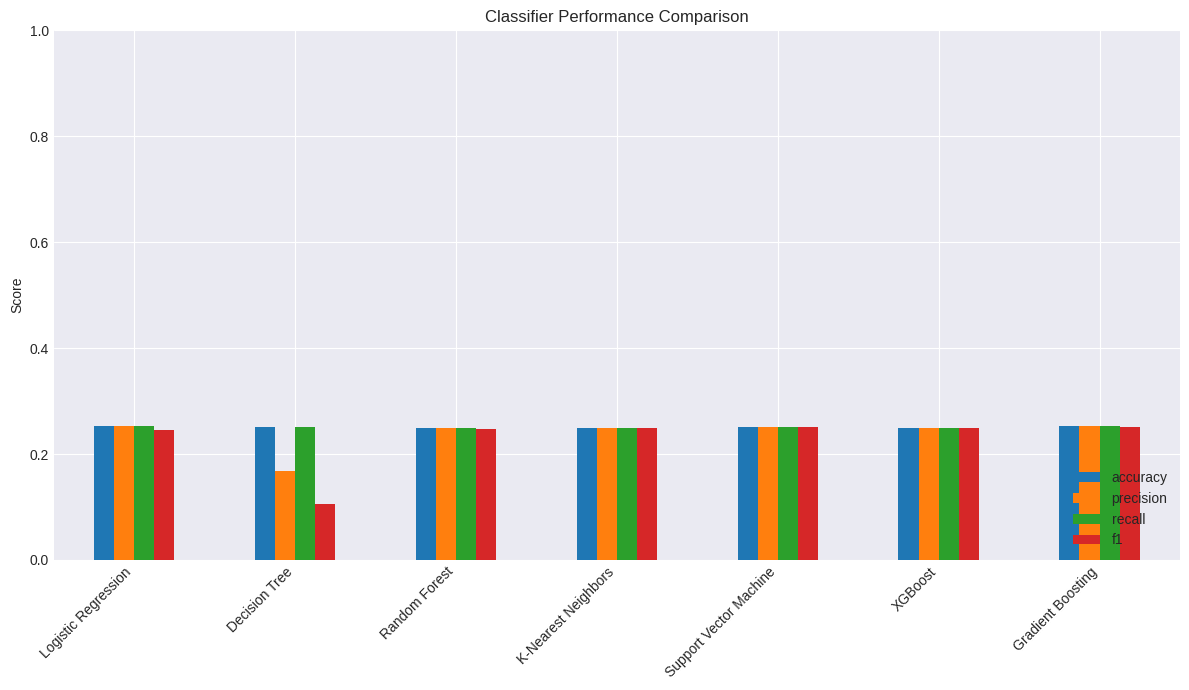


Project execution complete!


In [17]:
# --- Model Performance Summary ---
print("\n--- Model Performance Summary ---")
if results:
    performance_summary = pd.DataFrame.from_dict({key: {k: v for k, v in value.items() if k != 'confusion_matrix'} for key, value in results.items()}, orient='index')
    print(performance_summary)

    # Plotting performance metrics
    plt.figure(figsize=(12, 7))
    performance_summary[['accuracy', 'precision', 'recall', 'f1']].plot(kind='bar', ax=plt.gca())
    plt.title('Classifier Performance Comparison')
    plt.ylabel('Score')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0.0, 1.0) # Set a consistent y-axis limit for better comparison
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
else:
    print("No model results to display.")

print("\nProject execution complete!")




